
# Semantic Segmentation in Remote Sensing Images


<div>
<img src="https://www.researchgate.net/publication/327941585/figure/fig5/AS:686047147077633@1540577794361/An-example-from-the-dataset-A-remote-sensing-image-and-its-ground-truth-alongside-the.ppm" width="650"/>
</div>


## Modules

In [ ]:
%%capture
!pip install segmentation-models==1.0.1
import segmentation_models as sm
sm.set_framework('tf.keras')

In [ ]:
import numpy as np
import cv2
import os 
import re

import tensorflow as tf
from keras import backend as K
from tensorflow.python.keras.utils import data_utils
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, LearningRateScheduler

import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.offline as py
import plotly.express as px

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

import warnings
warnings.filterwarnings("ignore")

Mounted at /content/gdrive


In [ ]:
def atoi(text):
    return int(text) if text.isdigit() else text
def natural_keys(text):
    return [ atoi(c) for c in re.split('(\d+)',text) ]

In [ ]:
def visualize(**images):
    """
    PLot images in one row.
    Parameters
    ----------
    **images : ndarray
        Images sent for plotting.
        input image, ground_truth, generated_mask
    """
    n = len(images)
    plt.figure(figsize=(12, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([]) 
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [ ]:
def IoU(y_true, y_pred, threshold=0.5, smooth=1.):
    def threshold_binarize(x, threshold=0.5):
        ge = tf.greater_equal(x, tf.constant(threshold))
        y = tf.where(ge, x=tf.ones_like(x), y=tf.zeros_like(x))
        return y
    y_pred = threshold_binarize(y_pred, threshold)
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + smooth)


##Data Generator

In [ ]:
class DataGenerator(data_utils.Sequence): 
    """
    Generates data for Keras Sequence based data generator. 
    Suitable for building data generator for training and prediction.
    This class for a multiclass segmentation and superclass from
    tensorflow.keras.utils.Sequence
    Parameters
    ----------
    data_dir : string
        The parent name of the directory where the data is located.
        (Path to images and masks location.)
    to_fit : boolean, default=True
        Create a data generator based on this parameter 
        for training or prediction. True to return X and y, 
        False to return X only.
    batch_size : int, default=32
        Batch size at each iteration.
    dim : tuple or list, default=(256, 256)
        Tuple indicating for image dimension.
    dtype : , default=np.float32

    n_channels : int, default=3
        Number of image channels.
    n_classes : int, default=1
        Number of classes.
    shuffle : boolean, default=True
        True to shuffle label indexes after every epoch.
    seed : int, seed instance or None, default=None
        Determines random number generation for shuffle label indexes. 
        Use an int to make the randomness deterministic.
    """
    def __init__(self, data_dir, to_fit=True, batch_size=32, 
                 dim=(256, 256), dtype=np.float32, n_channels=3, 
                 n_classes=1, shuffle=True, seed=None):

        self.to_fit = to_fit
        self.batch_size = batch_size
        self.dim = dim
        self.dtype = dtype
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.seed = seed
        self.shuffle = shuffle
        self._n_batch = 0
        self._initialize_dirs(data_dir)
        self.on_epoch_end()

    def __len__(self):
        """
        Denotes the number of batches per epoch.
        Returns
        -------    
        num_batches : int    
            Number of batches per epoch.
        """
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        """
        Generate one batch of data.
        Parameters
        ----------
        index : int 
            Index of the batch.
        Returns
        ----------
        X : list of ndarray shape (batch_size, *dim, n_channels)
            Number of channels image up to batch size.
        y : list of ndarray shape (batch_size, *dim, n_classes)  
            Number of classes image up to batch size.
        X and y when fitting. X only when predicting.
        """
        if self._n_batch >= self.__len__():
            self.on_epoch_end
            self._n_batch = 0

        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        list_IDs_temp = [self.list_IDs[idx] for idx in indexes]

        X = self._generate_X(list_IDs_temp)
        self._n_batch += 1
        if self.to_fit:
            y = self._generate_y(list_IDs_temp)
            return X, y
        return X            

    def on_epoch_end(self):
        """
        Updates indexes after each epoch.
        Attributes
        ----------
        indexes : list of ndarray shape (len(filenames[1]),)
            It keeps the indices as high as the size of the masks.
            If shuffle is True, shuffle the data indices and updates
            after each epoch.
        """
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            if self.seed is not None:
                np.random.seed(self.seed)
            np.random.shuffle(self.indexes)

    def __iter__(self):
        """
        Create a generator that iterate over the DataGenerator.
        """
        while True:
            for item in (self[i] for i in range(len(self))):
                yield item

    def __next__(self):
        """
        Function returns the next batches in a DataGenerator.
        Returns
        ----------
        batches : list of ndarray (X, y) or X
            It is the data prepared as much as the 
            number of batches.
        """
        batches = self.__getitem__(self._n_batch)
        return batches
    
    def _initialize_dirs(self, directory):
        """
        Initialize the all data directories.
        The directory structure should be as follows.:
            data:
                test:
                    images:
                    masks:
                train:
                    images:
                    masks:
                val:
                    images:
                    masks:
        Attributes
        ----------
        filenames : list, size (2,)
            A list that keeps the full directories of images and masks.
            Index 0 is images. Index 1 is masks.
        list_IDs : list of ndarray shape (len(filenames[1]),)
            It keeps the indices as high as the size of the masks.
        """
        classes = []
        for subdir in sorted(os.listdir(directory)):
            if os.path.isdir(os.path.join(directory, subdir)):
                classes.append(subdir)

        filenames = []
        for dirpath in (os.path.join(directory, subdir) for subdir in classes):
            for roots,dirs,files in os.walk(dirpath):               
                if files:
                    sub_dirs = sorted([roots + os.sep + file for file in  files])
                    filenames.append(sub_dirs)
        
        self.filenames = filenames
        self.list_IDs = np.arange(len(filenames[0]))
        
    def _generate_X(self, list_IDs_temp):
        """
        Generates data containing batch_size images.        
        Parameters
        ----------
        list_IDs_temp : list
            List of masks ids to load.
        Returns
        ----------
        X : list of ndarray shape (batch_size, *dim, n_channels)
            Batch of images.
        """
        X = np.empty((self.batch_size, *self.dim, self.n_channels), dtype=self.dtype)

        for i, ID in enumerate(list_IDs_temp):
            img = cv2.imread(self.filenames[0][ID])
            img = cv2.resize(img, self.dim)
            X[i,] = img
        return X

    def _generate_y(self, list_IDs_temp):
        """
        Generates data containing batch_size masks.
        Parameters
        ----------
        list_IDs_temp : list
            List of masks ids to load.
        Returns
        ----------
        y : list of ndarray shape (batch_size, *dim, n_classes)
            Batch of masks.
        """
        y = np.empty((self.batch_size, *self.dim, self.n_classes), dtype=self.dtype)

        for i, ID in enumerate(list_IDs_temp):
            mask = cv2.imread(self.filenames[1][ID], 0)
            mask = cv2.resize(mask, self.dim)
            if self.n_classes is not 1:
                mask = to_categorical(mask, num_classes=self.n_classes, dtype=self.dtype)
            else:
                mask = np.expand_dims(mask, axis=-1)
            y[i,] = mask
        return y

In [ ]:
%%capture
!unzip /content/gdrive/MyDrive/Datas/UV_dataset/Train.zip -d "/content/"
!unzip /content/gdrive/MyDrive/Datas/UV_dataset/Val.zip -d "/content/"
!unzip /content/gdrive/MyDrive/Datas/UV_dataset/Test.zip -d "/content/"



> Some hyperparameters



In [ ]:
train_path = "/content/Train/Rural"
test_path = "/content/Val/Rural"
val_path = "/content/Val/Rural"

backbone = 'efficientnetb3'
n_classes = 8
activation = 'sigmoid' if n_classes == 1 else 'softmax'
num_epoch = 30
LR = 1e-3
batch_size = 16
IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS = 256, 256, 3 
seed = None 

if K.image_data_format() == 'channels_first':
    input_shape = (3, IMG_WIDTH, IMG_HEIGHT)
else:
    input_shape = (IMG_WIDTH, IMG_HEIGHT, 3)

params = {'to_fit':True,
          'batch_size': batch_size,
          'dim': (IMG_WIDTH,IMG_HEIGHT),
          'dtype':'float32',
          'n_channels': IMG_CHANNELS,
          'n_classes': n_classes,
          'shuffle': False,
          'seed':seed}

train_generator = DataGenerator(train_path, **params)
val_generator = DataGenerator(val_path, **params)
test_generator = DataGenerator(test_path, batch_size=100, dim=(IMG_WIDTH,IMG_HEIGHT), dtype='float32', n_classes=n_classes)



> Visualize the data



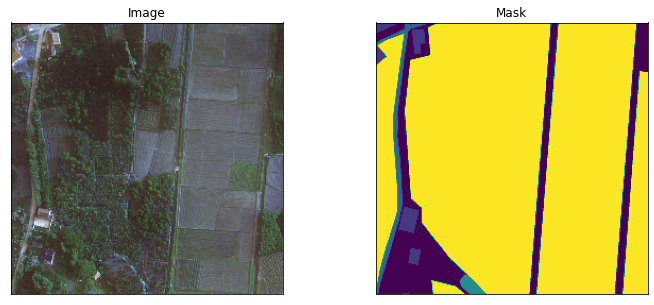

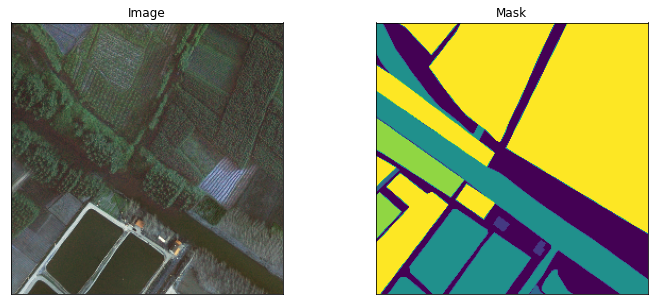

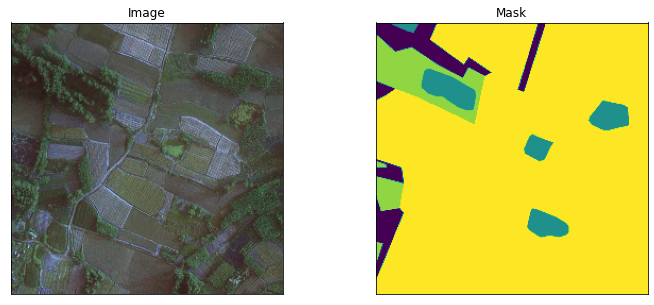

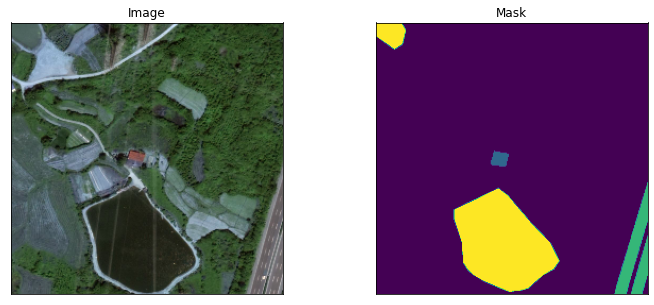

In [ ]:
images, masks = next(train_generator)
for image, mask in zip(images, masks):
    visualize(
        image=image.astype('uint8'),
        mask=np.argmax(np.squeeze(mask), axis=2)
    )


## CNN Approaches




```
Backbones
*********************************************************************
VGG
'vgg16' 'vgg19'
ResNet
'resnet18' 'resnet34' 'resnet50' 'resnet101' 'resnet152'
SE-ResNet
'seresnet18' 'seresnet34' 'seresnet50' 'seresnet101' 'seresnet152'
ResNeXt
'resnext50' 'resnext101'
SE-ResNeXt
'seresnext50' 'seresnext101'
SENet154
'senet154'
DenseNet
'densenet121' 'densenet169' 'densenet201'
Inception
'inceptionv3' 'inceptionresnetv2'
MobileNet
'mobilenet' 'mobilenetv2'
EfficientNet
'efficientnetb0' 'efficientnetb1' 'efficientnetb2' 'efficientnetb3' 'efficientnetb4' 'efficientnetb5' efficientnetb6' efficientnetb7'
*********************************************************************

```



#### U-Net

<div>
<img src="https://github.com/qubvel/segmentation_models/blob/master/images/unet.png?raw=true" width="450"/>
</div>

[Link](https://https://arxiv.org/pdf/1505.04597.pdf)

In [ ]:
optim = tf.keras.optimizers.Adam(LR)
_dice_loss = sm.losses.DiceLoss() 
_focal_loss = sm.losses.BinaryFocalLoss() 
total_loss = _dice_loss + _focal_loss
metrics = [sm.metrics.IOUScore(threshold=0.5)]
model_filename = '/content/RSI_unet_{}_{}_{}.h5'.format(IMG_WIDTH, num_epoch, backbone)

callback_checkpoint = ModelCheckpoint(
    model_filename, 
    verbose=1, 
    monitor='loss', 
    save_weights_only=True,
    save_best_only=True,
    mode='min'
)

callbacks = [
    callback_checkpoint,
    tf.keras.callbacks.ReduceLROnPlateau(),
]

preprocess_input = sm.get_preprocessing(backbone)

model_unet = sm.Unet(
    backbone, 
    encoder_weights='imagenet',
    input_shape=input_shape, 
    classes=n_classes, 
    activation=activation
)

model_unet.compile(
    optimizer=optim,
    loss=total_loss,
    metrics=metrics,
)

history_unet = model_unet.fit(
    train_generator,
    validation_data=val_generator,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator),
    epochs=num_epoch,
    callbacks=callbacks,
    verbose = 1
)

44122112/44107200 [==============================] - 1s 0us/step
Epoch 1/30
85/85 [==============================] - ETA: 0s - loss: 0.6198 - iou_score: 0.3776
Epoch 1: loss improved from inf to 0.61985, saving model to /content/motility_unet_256_30_efficientnetb3.h5
85/85 [==============================] - 129s 1s/step - loss: 0.6198 - iou_score: 0.3776 - val_loss: 1.0170 - val_iou_score: 0.1958 - lr: 0.0010
Epoch 2/30
85/85 [==============================] - ETA: 0s - loss: 0.4221 - iou_score: 0.5425
Epoch 2: loss improved from 0.61985 to 0.42215, saving model to /content/motility_unet_256_30_efficientnetb3.h5
85/85 [==============================] - 100s 1s/step - loss: 0.4221 - iou_score: 0.5425 - val_loss: 0.7650 - val_iou_score: 0.3060 - lr: 0.0010
Epoch 3/30
85/85 [==============================] - ETA: 0s - loss: 0.3792 - iou_score: 0.5774
Epoch 3: loss improved from 0.42215 to 0.37915, saving model to /content/motility_unet_256_30_efficientnetb3.h5
85/85 [=====================

#### LinkNet

<div>
<img src="https://github.com/qubvel/segmentation_models/blob/master/images/linknet.png?raw=true" width="450"/>
</div>

[Link](https://arxiv.org/pdf/1707.03718.pdf)

In [ ]:
model_filename = '/content/RSI_linknet_{}_{}_{}.h5'.format(IMG_WIDTH, num_epoch, backbone)

callback_checkpoint = ModelCheckpoint(
    model_filename, 
    verbose=1, 
    monitor='loss', 
    save_weights_only=True,
    save_best_only=True,
    mode='min'
)

callbacks = [
    callback_checkpoint,
    tf.keras.callbacks.ReduceLROnPlateau(),
]

preprocess_input = sm.get_preprocessing(backbone)

model_linknet = sm.Linknet(
    backbone, 
    encoder_weights='imagenet',
    input_shape=input_shape, 
    classes=n_classes, 
    activation=activation
)

model_linknet.compile(
    optimizer=optim,
    loss=total_loss,
    metrics=metrics,
)

history_linknet = model_linknet.fit(
    train_generator,
    validation_data=val_generator,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator),
    epochs=num_epoch,
    callbacks=callbacks,
    verbose = 1
)

Epoch 1/30
85/85 [==============================] - ETA: 0s - loss: 0.6904 - iou_score: 0.3195
Epoch 1: loss improved from inf to 0.69045, saving model to /content/motility_linknet_256_30_efficientnetb3.h5
85/85 [==============================] - 119s 1s/step - loss: 0.6904 - iou_score: 0.3195 - val_loss: 0.8072 - val_iou_score: 0.2483 - lr: 1.0000e-04
Epoch 2/30
85/85 [==============================] - ETA: 0s - loss: 0.4649 - iou_score: 0.5304
Epoch 2: loss improved from 0.69045 to 0.46495, saving model to /content/motility_linknet_256_30_efficientnetb3.h5
85/85 [==============================] - 92s 1s/step - loss: 0.4649 - iou_score: 0.5304 - val_loss: 0.6509 - val_iou_score: 0.3789 - lr: 1.0000e-04
Epoch 3/30
85/85 [==============================] - ETA: 0s - loss: 0.3791 - iou_score: 0.5996
Epoch 3: loss improved from 0.46495 to 0.37911, saving model to /content/motility_linknet_256_30_efficientnetb3.h5
85/85 [==============================] - 100s 1s/step - loss: 0.3791 - iou_sc

#### FPN


<div>
<img src="https://github.com/qubvel/segmentation_models/blob/master/images/fpn.png?raw=true" width="450"/>
</div>

[Link](http://presentations.cocodataset.org/COCO17-Stuff-FAIR.pdf)

In [ ]:
model_filename = '/content/RSI_fpn_{}_{}_{}.h5'.format(IMG_WIDTH, num_epoch, backbone)

callback_checkpoint = ModelCheckpoint(
    model_filename, 
    verbose=1, 
    monitor='loss', 
    save_weights_only=True,
    save_best_only=True,
    mode='min'
)

callbacks = [
    callback_checkpoint,
    tf.keras.callbacks.ReduceLROnPlateau(),
]

preprocess_input = sm.get_preprocessing(backbone)

model_fpn = sm.FPN(
    backbone, 
    encoder_weights='imagenet',
    input_shape=input_shape, 
    classes=n_classes, 
    activation=activation
)

model_fpn.compile(
    optimizer=optim,
    loss=total_loss,
    metrics=metrics,
)

history_fpn = model_fpn.fit(
    train_generator,
    validation_data=val_generator,
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator),
    epochs=num_epoch,
    callbacks=callbacks,
    verbose = 1
)

Epoch 1/30
85/85 [==============================] - ETA: 0s - loss: 0.8868 - iou_score: 0.0912
Epoch 1: loss improved from inf to 0.88676, saving model to /content/motility_fpn_256_30_efficientnetb3.h5
85/85 [==============================] - 131s 1s/step - loss: 0.8868 - iou_score: 0.0912 - val_loss: 0.9282 - val_iou_score: 0.0373 - lr: 1.0000e-06
Epoch 2/30
85/85 [==============================] - ETA: 0s - loss: 0.7978 - iou_score: 0.2061
Epoch 2: loss improved from 0.88676 to 0.79775, saving model to /content/motility_fpn_256_30_efficientnetb3.h5
85/85 [==============================] - 103s 1s/step - loss: 0.7978 - iou_score: 0.2061 - val_loss: 0.8642 - val_iou_score: 0.1339 - lr: 1.0000e-06
Epoch 3/30
85/85 [==============================] - ETA: 0s - loss: 0.7425 - iou_score: 0.2755
Epoch 3: loss improved from 0.79775 to 0.74250, saving model to /content/motility_fpn_256_30_efficientnetb3.h5
85/85 [==============================] - 108s 1s/step - loss: 0.7425 - iou_score: 0.2755

## Evaluation

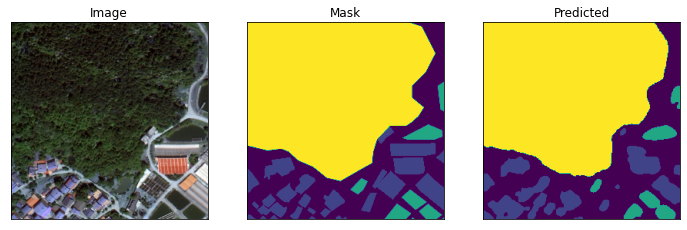

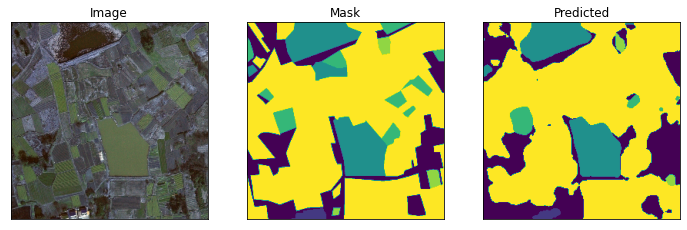

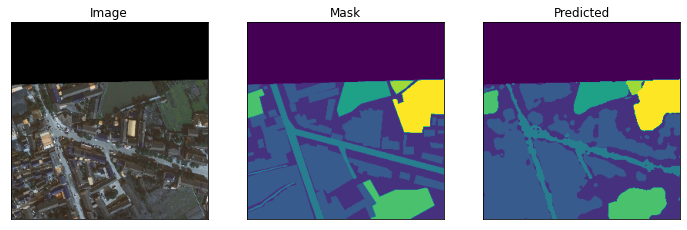

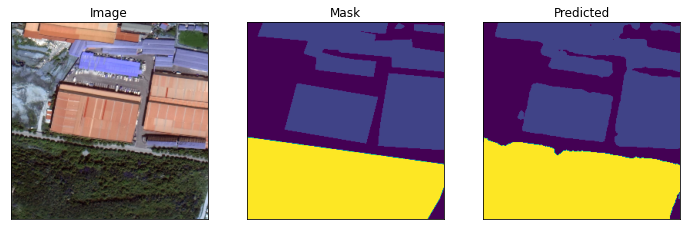

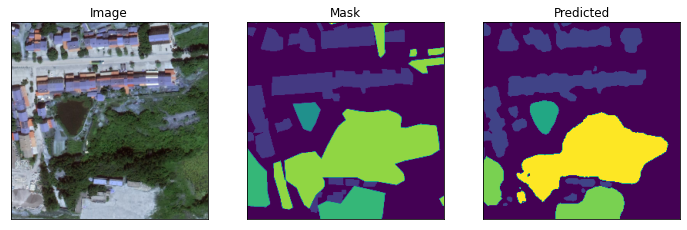

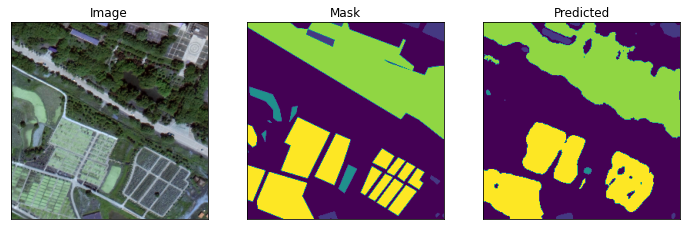

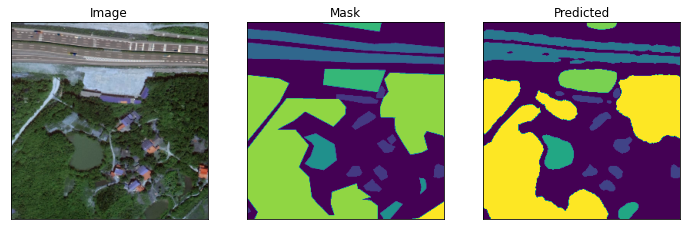

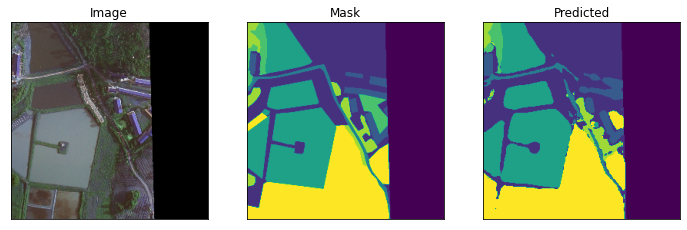

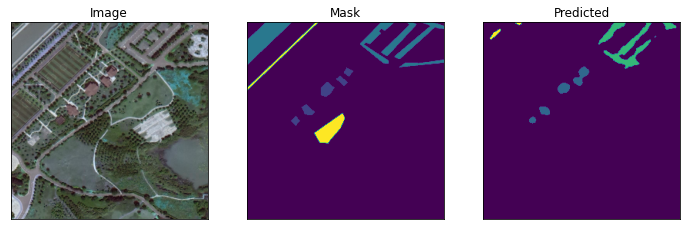

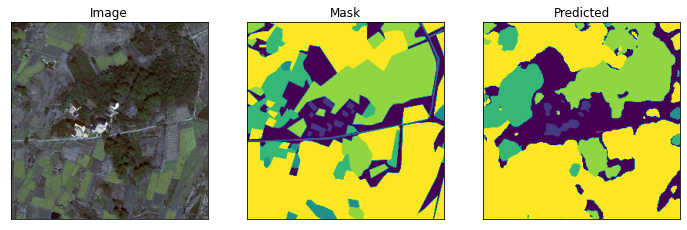

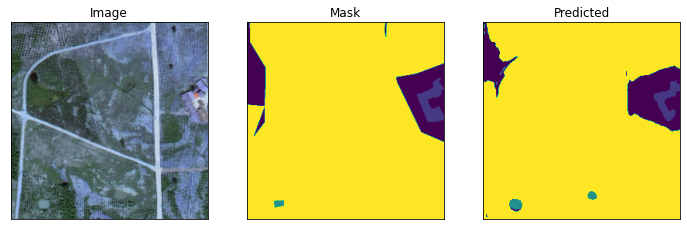

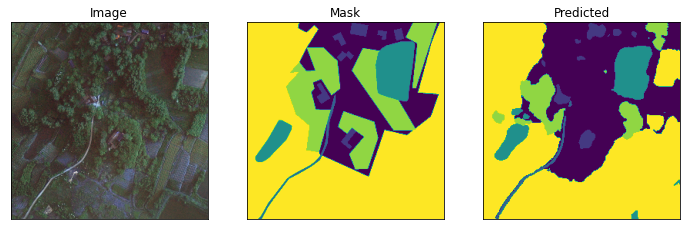

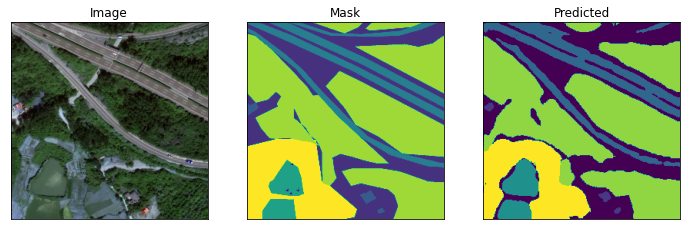

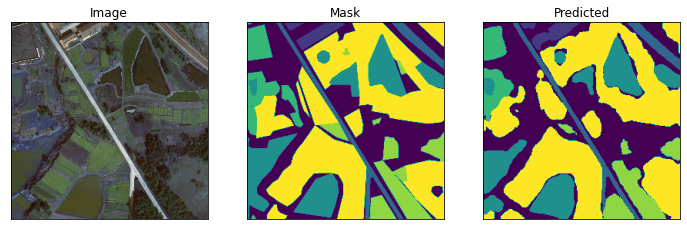

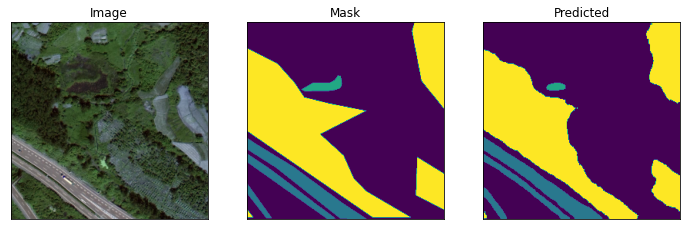

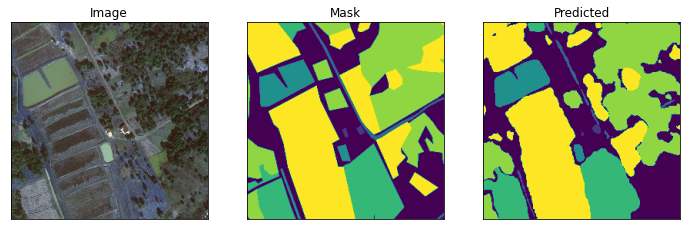

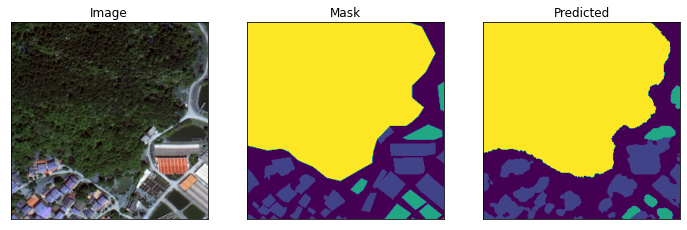

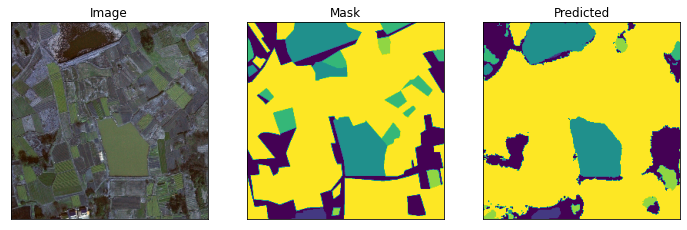

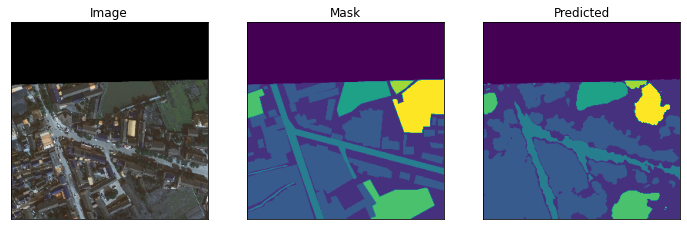

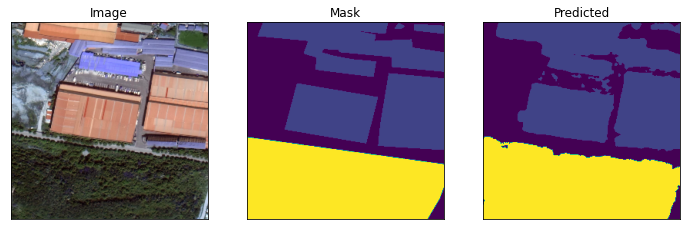

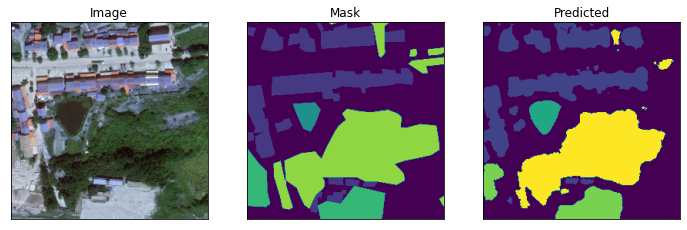

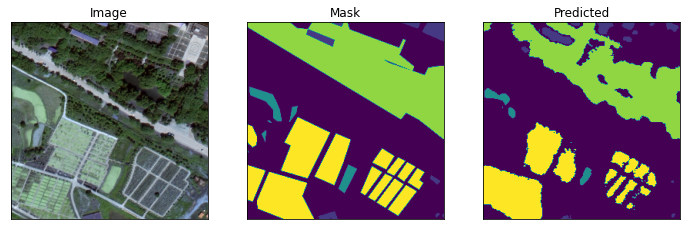

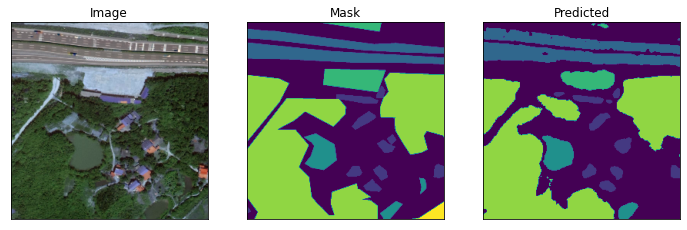

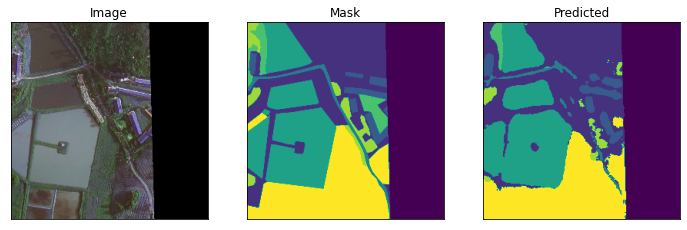

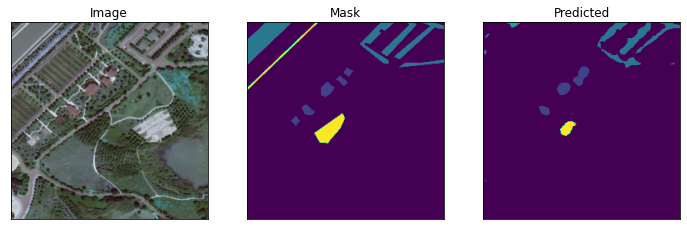

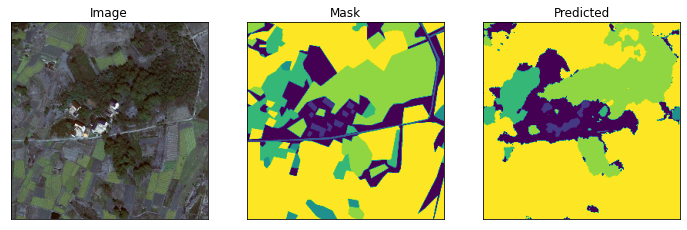

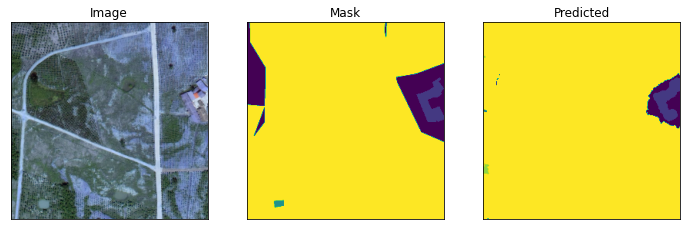

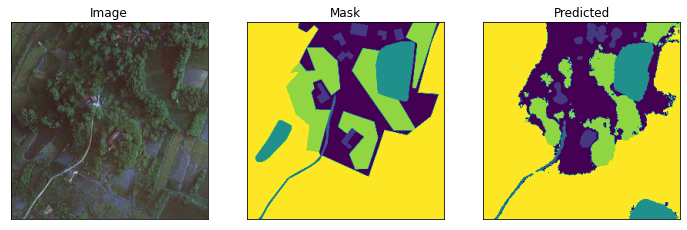

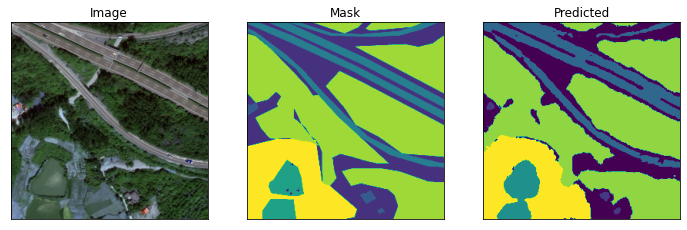

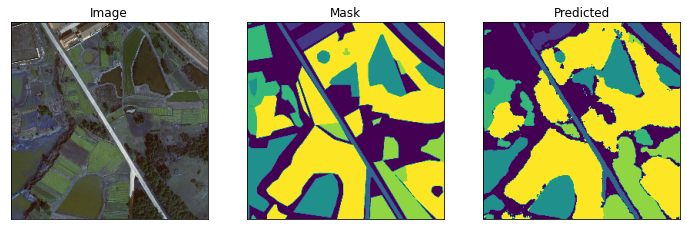

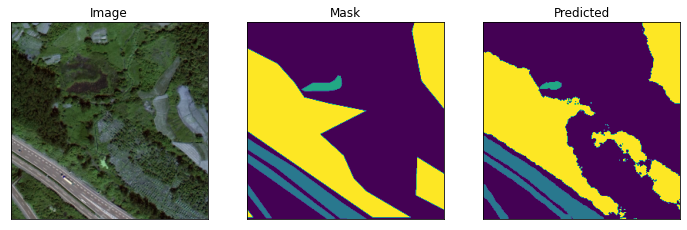

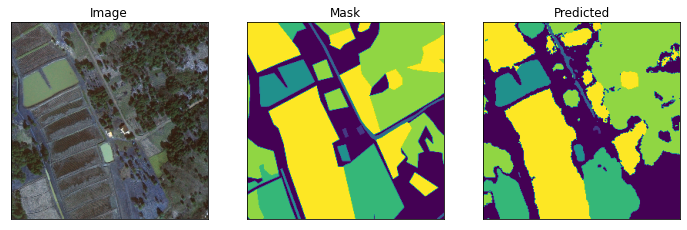

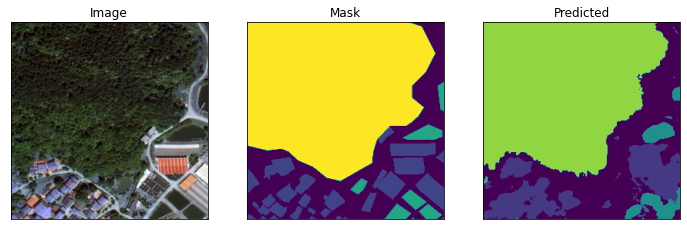

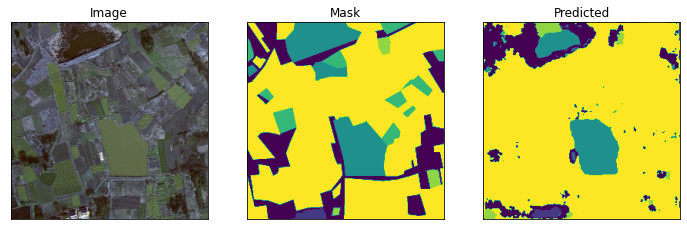

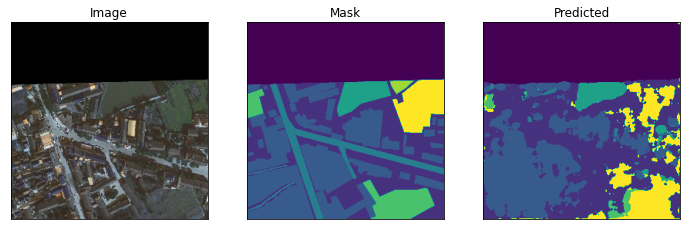

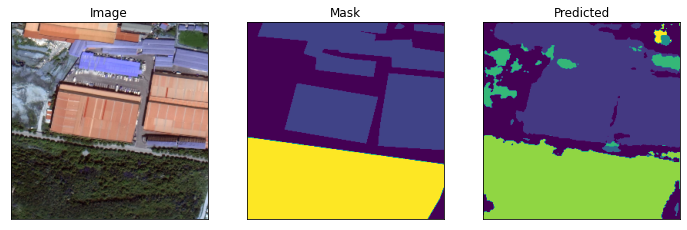

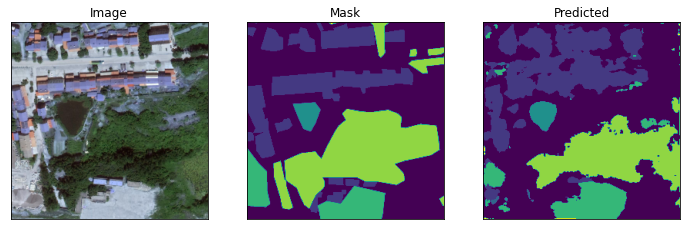

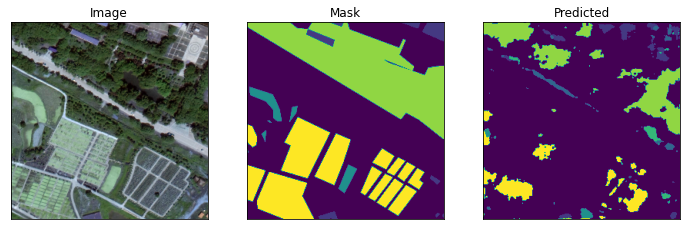

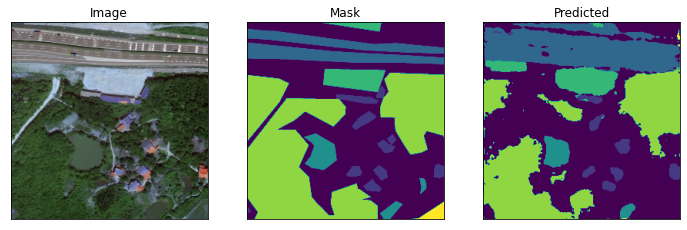

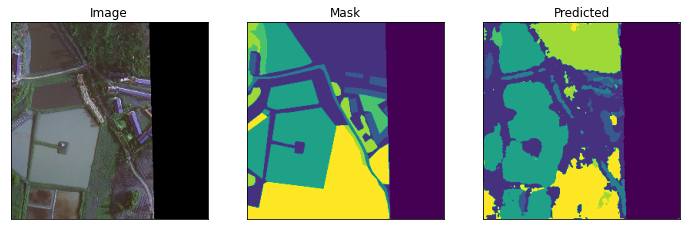

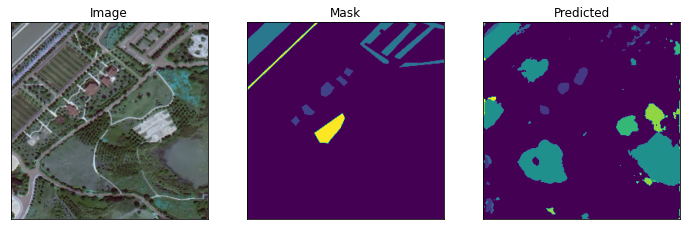

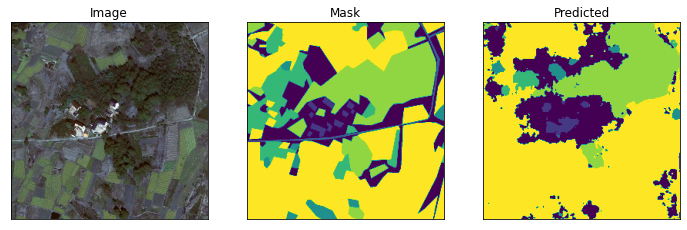

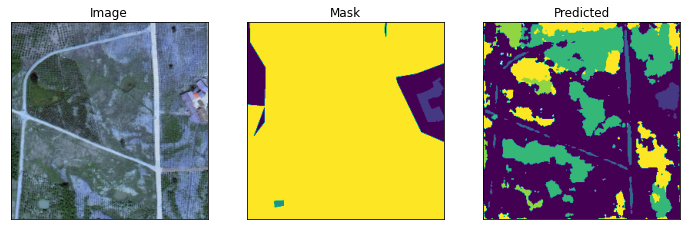

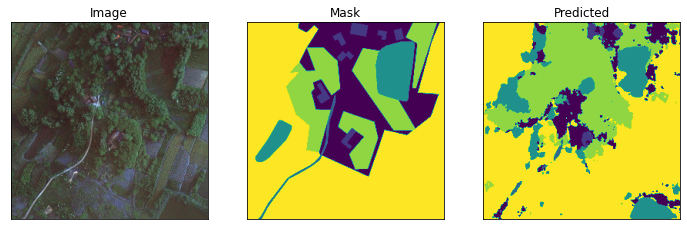

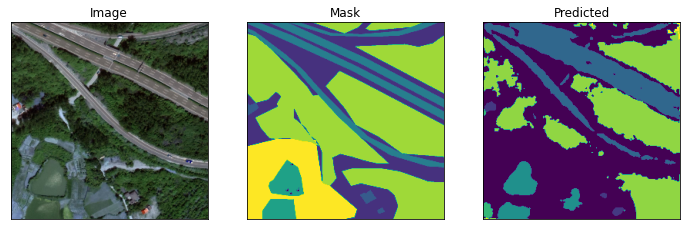

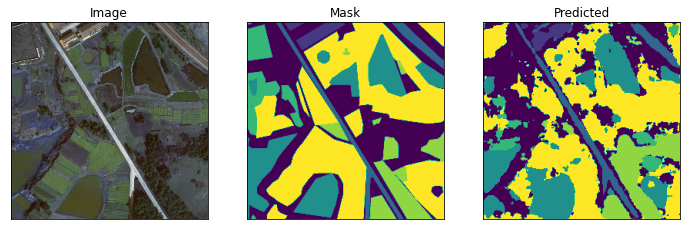

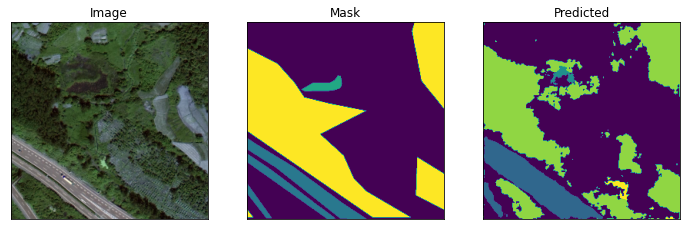

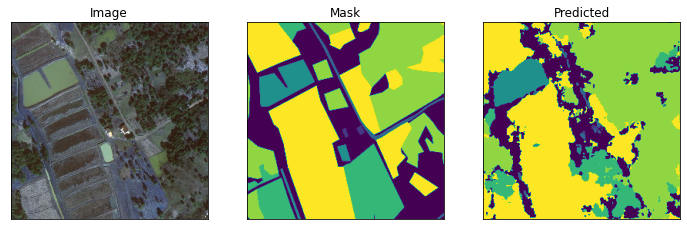

In [ ]:
images, masks = next(train_generator)
models = [model_unet, model_linknet, model_fpn]
for model in models:
    for image, mask in zip(images, masks):
        predicted = model.predict(np.array([image]))
        visualize(
            image=image.astype('uint8'),
            mask=np.argmax(np.squeeze(mask), axis=2),
            predicted=np.argmax(np.squeeze(predicted), axis=2)
        )



> Avg. Best Benchmark Score: 0.54294 (in this data-set)



In [ ]:
iou_scores={
    'unet':[],
    'linknet':[],
    'fpn':[],
}
images, masks = next(test_generator)
for model, model_name in zip(models, list(iou_scores.keys())):
    predictions = model.predict(images)
    for index, prediction in enumerate(predictions):
        iou_scores[model_name].append(
            float(IoU(prediction, 
                      masks[index]))
        )

In [ ]:
fig = go.Figure()
for key in iou_scores.keys():
    fig.add_trace(go.Box(
        y=iou_scores[key],
        name = key,
        marker_color='dodgerblue',
        boxpoints='all',
        boxmean='sd',
        jitter=0.5,
        whiskerwidth=0.9,
        marker_size=2,
        line_width=1
    ))

fig.update_layout(
    title_text='Avg. IoU Score',
    showlegend=True,
    yaxis=dict(
        title="IoU",
        showgrid=False,
        showline=False,
        showticklabels=True,
    ),
    xaxis=dict(
        title="Models",
        autorange=True,
        showgrid=True,
        zeroline=True,
        gridcolor='rgb(255, 255, 255)',
        gridwidth=1,
        zerolinecolor='rgb(255, 255, 255)',
        zerolinewidth=2,
    ),
    width=650,
    height=450)
fig.show()